In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=''

import tensorflow as tf
import numpy as np
import numpy.random as rng
import numpy as np
import matplotlib.pyplot as plt
import random
import operator
from utils.utils import tf_matmul_r, tf_matmul_l, tf_eigvecs, tf_eigvals


In [17]:
np.random.randint(0,2,size=[2])

array([1, 1])

In [18]:
# inshape=30
# hidden=20
# outshape=10
# batch_size=50
# T = rng.randn(outshape, inshape)
def traindata(batch_size):
    train_x=np.zeros((batch_size,2))
    train_y=np.zeros((batch_size))
    for i in range(batch_size):
        inp=np.random.randint(0,2,size=[1,2])
        output=operator.xor(inp[0,0],inp[0,1])
        train_x[i,:]=inp
        train_y[i]=output
    return (train_x, train_y)

In [19]:
batch_size=50

x,y=traindata(10)
x



array([[1., 0.],
       [1., 0.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [20]:
y

array([1., 1., 0., 1., 1., 0., 1., 1., 1., 1.])

In [21]:
#p = self.config.state_size[0]
p=2# inshape 
m =10# hiddenshap
j = 1#outshpae
#n = 10
var_xi = 0.01
learning_rate=1e-3
lmda_learning_rate=1e-1
#lmda_learning_rate=0
#Training data inputs
x=tf.placeholder(tf.float32,[None,p], name = 'x')
y=tf.placeholder(tf.float32,[None,j], name = 'y')

#Scale weight initialization
alpha0 = np.sqrt(2.0/p)
alpha1 = np.sqrt(2.0/m)
alpha2 = np.sqrt(2.0/j)
alpha3 = 1

A = tf.Variable(rng.randn(p+1,m)*alpha0, name="hidden_weights", dtype=tf.float32)
W = tf.Variable(rng.randn(m+1,j)*alpha1, name="output_weights", dtype=tf.float32)
B = tf.Variable(rng.randn(m+1,j)*alpha1, name="feedback_weights", dtype=tf.float32)

# network architecture with ones added for bias terms
#0 = tf.ones([batch_size, 1], tf.float32)
#1 = tf.ones([batch_size, 1], tf.float32)
e0 = tf.ones([tf.shape(x)[0], 1], tf.float32)
e1 = tf.ones([tf.shape(x)[0], 1], tf.float32)
# e0 = tf.ones([1,batch_size], tf.float32)
# e1 = tf.ones([1,batch_size], tf.float32)

x_aug = tf.concat([x, e0], 1)
h = tf.sigmoid(tf.matmul(x_aug, A))
#Make some noise
h_aug = tf.concat([h, e1], 1)
xi = tf.random_normal(shape=tf.shape(h_aug), mean=0.0, stddev=var_xi, dtype=tf.float32)
h_tilde = h_aug + xi
#Add noise to hidden layer
#y_p = tf.sigmoid(tf.matmul(h_tilde, W))
y_p = tf.matmul(h_tilde, W)
y_p_0 = tf.matmul(h_aug, W)

trainable = [A, W, B]


In [22]:
tf.shape(x)[0]

<tf.Tensor 'strided_slice_12:0' shape=() dtype=int32>

In [23]:
#mean squared error
loss = tf.reduce_sum(tf.pow(y_p-y, 2))/2
loss_0 = tf.reduce_sum(tf.pow(y_p_0-y, 2))/2
e = (y_p - y)

h_prime = tf.multiply(h_tilde, 1-h_tilde)[:,0:m]

#Feedback data for saving
#Only take first item in epoch
delta_bp = tf.matmul(e, tf.transpose(W[0:m,:]))[0,:]
delta_fa = tf.matmul(e, tf.transpose(B[0:m,:]))[0,:]
norm_W = tf.norm(W)
norm_B = tf.norm(B)
error_FA = tf.norm(delta_bp - delta_fa)
alignment = tf.reduce_sum(tf.multiply(delta_fa,delta_bp))/tf.norm(delta_fa)/tf.norm(delta_bp)
norm_diff = tf.norm(W - B)
eigs = tf_eigvals(tf.matmul(tf.transpose(B), W))

#Compute updates for W and A (based on B)
#Node pert
lmda = tf.matmul(e, tf.transpose(B[0:m,:]))
#Backprop
#lmda = tf.matmul(e, tf.transpose(W[0:m,:]))
grad_W = tf.gradients(xs=W, ys=loss)[0]
grad_A = tf.matmul(tf.transpose(x_aug), tf.multiply(h_prime, lmda))
grad_B = tf.matmul(tf.matmul(B, tf.transpose(e)) - tf.transpose(xi)*(loss - loss_0)/var_xi, e)

new_W = W.assign(W - learning_rate*grad_W)
new_A = A.assign(A - learning_rate*grad_A)            
new_B = B.assign(B - lmda_learning_rate
                 *grad_B)            
train_step = [new_W, new_A, new_B]
correct_prediction = tf.equal(tf.argmax(y_p, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#Also need to add eigenvector stuff
training_metrics = [alignment, norm_W, norm_B, error_FA, eigs[0]]

In [24]:
init = tf.global_variables_initializer()

N = 20000

store_al=[]
store_df=[]
store_err=[]
store_out=np.zeros((N, 4))
x_in=[[0,0],[0,1],[1,0],[1,1]]

with tf.Session() as sess:

    sess.run(init)
    for idx in range(N):
        (train_x, train_y) = traindata(batch_size)
        train_x=np.float32(train_x)
        train_y=(np.float32(train_y))
        train_y=train_y.reshape((batch_size,1))#to make it [50,1] instead of [50,]
        
        _,align,diff,err=sess.run([train_step,alignment,norm_diff,loss_0],feed_dict={x: train_x, y: train_y})
        out=sess.run([y_p],feed_dict={x: x_in})

        store_out[idx,:] = out[0][:,0]
        store_err.append(err)
        store_al.append(align)
        store_df.append(diff)
        #print(align)
    W_end = W.eval()
    B_end = B.eval()
    A_end = B.eval()

In [25]:
store_out

array([[ 0.12233105,  0.61627889,  0.31831649,  0.7125206 ],
       [ 0.13434017,  0.6162371 ,  0.33622497,  0.71556383],
       [ 0.15427366,  0.63156694,  0.35386023,  0.72610474],
       ...,
       [-0.0488869 ,  1.01586545,  1.15974545, -0.02850056],
       [-0.03226388,  1.03370833,  1.04678881,  0.07918966],
       [ 0.14662945,  0.83810151,  1.0366745 ,  0.07523751]])

In [11]:
print(B_end, np.linalg.norm(B_end))
print(W_end, np.linalg.norm(W_end))

[[-0.549147  ]
 [ 0.9215565 ]
 [ 0.7830039 ]
 [ 1.2101835 ]
 [-1.2584617 ]
 [ 0.10347324]
 [-0.22291185]
 [-0.16238396]
 [-0.05648081]
 [-0.05955124]
 [-0.28186762]] 2.2327437
[[-2.0438952]
 [ 3.5462174]
 [ 2.8764968]
 [ 4.2808776]
 [-4.5642467]
 [ 0.4053457]
 [-0.8791507]
 [-0.5551104]
 [-0.200745 ]
 [-0.1725211]
 [-0.8917337]] 8.142252


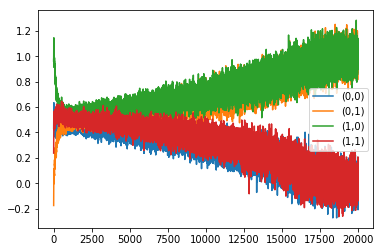

In [12]:
plt.plot(range(N), store_out)
plt.legend(['(0,0)','(0,1)','(1,0)','(1,1)'])
plt.show()

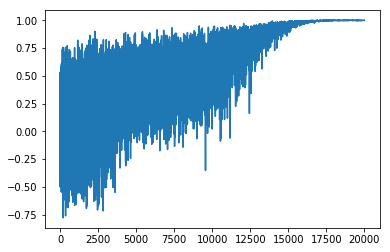

In [13]:
plt.plot(store_al)
plt.show()

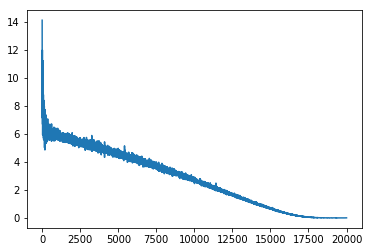

In [14]:
plt.plot(store_err)
plt.show()

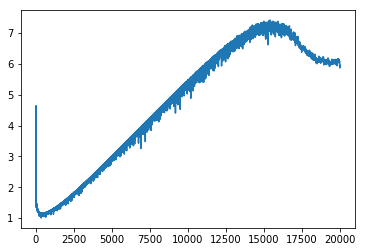

In [15]:
plt.plot(store_df)
plt.show()